# Simple CNN for Edgelovers

Trainieren eines sehr einfachen CNN mit nur einem Kernel, um Bilder mit vertikalen (y=0) von solchen mit horizontalen Streifen (y=1) zu unterscheiden.

## Setup

### Einbinden von Paketen

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

np.__version__, tf.__version__

('1.23.4', '2.11.0')

## 1. Daten generieren

Erstellen einer Funktion, die einen künstlichen Datensatz von Graustufenbildern (50x50 Pixel) mit 10 vertikalen oder horizontalen Balken (10 Pixel lang) erstellt. Verwenden dieser Funktion, um einen Trainings- und einen Validierungsdatensatz mit jeweils 1000 Beispielen zu erstellen.

In [18]:
def create_dataset(num_examples):
    dataset = []
    img_label = []
    for i in range(num_examples):
        img = np.zeros((50, 50))
        
        orientation = random.choice(['vertical', 'horizontal'])

        # create label, 1 = vertical, 0 = horizontal
        if orientation == 'vertical':
            label = 1
        else:
            label = 0    

        # draw the bars on the image
        for j in range(10):
            # starting position for the bars
            if orientation == 'vertical':
                start_pos = (random.randint(0, 40), random.randint(0, 49))
            else:
                start_pos = (random.randint(0, 49), random.randint(0, 40))
            # fill array with bar
            for k in range(10):
                if orientation == 'vertical':
                    img[start_pos[0]+k][start_pos[1]] = 255
                else:
                    img[start_pos[0]][start_pos[1]+k] = 255
        # add the image to the dataset
        dataset.append(img)
        img_label.append(label)
    return dataset, img_label


train_data, train_label = create_dataset(1000)
validation_data, validation_label = create_dataset(1000)

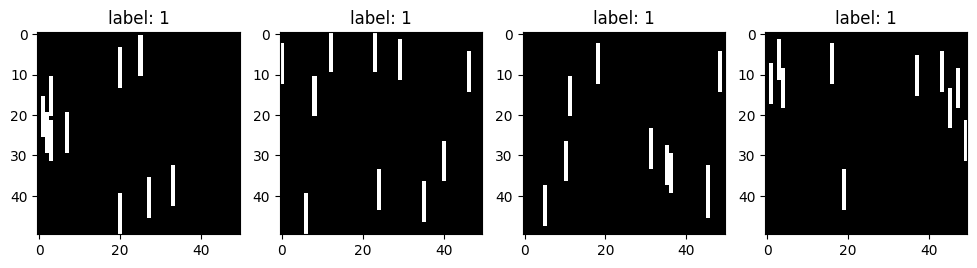

In [19]:
plt.figure(figsize=(12,12))
for i in range(0,4):
    plt.subplot(1,4,(i+1))
    plt.imshow((train_data[i]),cmap="gray")
    plt.title('label: '+ str(train_label[i]))

In [20]:
X_train = np.array(train_data, dtype=float)
Y_train = np.array(train_label, dtype=int)
X_validation = np.array(validation_data, dtype=float)
Y_validation = np.array(validation_label, dtype=int)

print(X_train.shape) 
print(Y_train.shape) 

(1000, 50, 50)
(1000,)


## 2. Baue ein möglichst einfaches CNN

Erstellen eines CNN mit einer Faltung (5x5, mit zwei Ausgängen (einer für horizontal, einer für vertikal). Trainieren des CNN mit den zuvor generierten Daten. 
Das Netz sollte nicht mehr als 30 trainierbare Parameter haben.

In [89]:

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import optimizers

model = keras.Sequential()
model.add(Convolution2D(filters=1, kernel_size=(5, 5), input_shape=(50, 50, 1), use_bias=False)) #Kernel size 10 is way better
model.add(MaxPooling2D(pool_size=(2,2))) #different max Pooling for less parameters ?

model.add(Flatten())
model.add(Dense(1, activation='sigmoid', use_bias=False))

# compile the model and intitialize weights
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [90]:
# summarize model along with number of model weights
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 46, 46, 1)         25        
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 23, 23, 1)        0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 529)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 529       
                                                                 
Total params: 554
Trainable params: 554
Non-trainable params: 0
_________________________________________________________________


Trainieren des Modells:

In [91]:
history = model.fit(X_train, Y_train, epochs=15, validation_data=(X_validation, Y_validation))

Epoch 1/15
32/32 [==============================] - 1s 24ms/step - loss: 16.8378 - accuracy: 0.5030 - val_loss: 12.6340 - val_accuracy: 0.5550
Epoch 2/15
32/32 [==============================] - 1s 19ms/step - loss: 8.7931 - accuracy: 0.6110 - val_loss: 7.6293 - val_accuracy: 0.6210
Epoch 3/15
32/32 [==============================] - 1s 19ms/step - loss: 4.4144 - accuracy: 0.7450 - val_loss: 3.4373 - val_accuracy: 0.7660
Epoch 4/15
32/32 [==============================] - 1s 20ms/step - loss: 1.6380 - accuracy: 0.8720 - val_loss: 1.3308 - val_accuracy: 0.8960
Epoch 5/15
32/32 [==============================] - 1s 19ms/step - loss: 0.5062 - accuracy: 0.9460 - val_loss: 0.6028 - val_accuracy: 0.9470
Epoch 6/15
32/32 [==============================] - 1s 18ms/step - loss: 0.1598 - accuracy: 0.9840 - val_loss: 0.3499 - val_accuracy: 0.9590
Epoch 7/15
32/32 [==============================] - 1s 18ms/step - loss: 0.0626 - accuracy: 0.9940 - val_loss: 0.2748 - val_accuracy: 0.9650
Epoch 8/15


Aufzeichnen der Lernkurve:

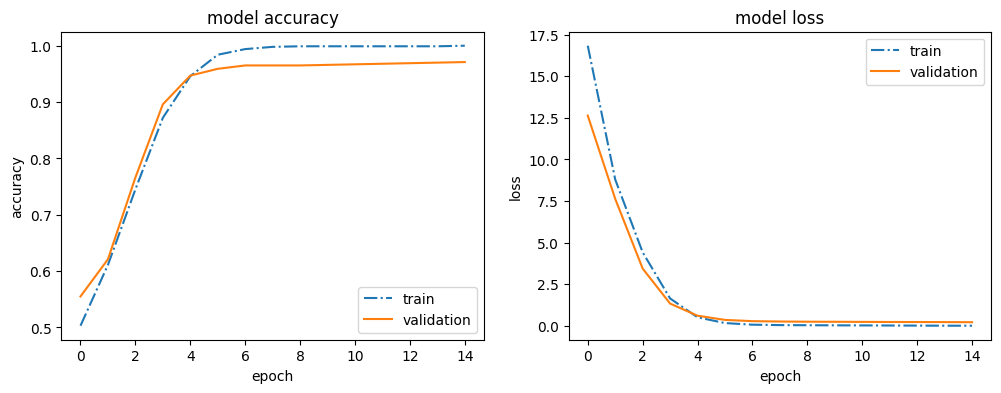

In [92]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

## 3. Visualisieren Sie den gelernten Kernel

Visualisierung des gelernten Kernel, indem Sie `model.get_weights()` verwenden.

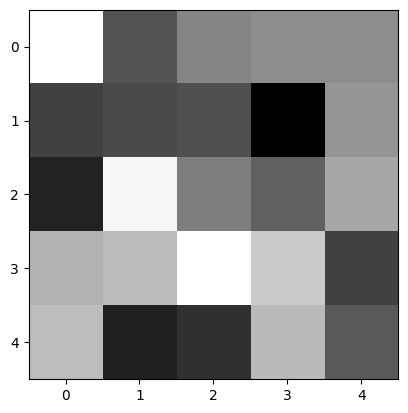

In [93]:
# Extract the kernel weights from the model
weights = model.get_weights()[0]

# Reshape the data to (5, 5)
weights = weights.reshape(5, 5)

# Plot the kernel weights as an image using matplotlib
plt.imshow(weights, cmap='gray')
plt.show()